In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
import tensorflow as tf
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"

In [2]:
X.shape

(17615, 100, 100)

In [3]:
X, y = shuffle(X, y, random_state=0)

In [4]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [5]:
X = tf.keras.applications.vgg19.preprocess_input(
    X, data_format=None
)

In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam 

In [7]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y) 

In [8]:
model = Sequential()

conv_base = VGG19(input_shape=(100,100,3), include_top=False, pooling='max',weights='imagenet')
# conv_base.trainable = False
model.add(conv_base)
# model.add(BatchNormalization())
# model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
# model.add(BatchNormalization())
model.add(Dense(5, activation='softmax')) 

# train_layers = [layer for layer in conv_base.layers[::-1][:5]]

# for layer in conv_base.layers:
#   if layer in train_layers:
#     layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [9]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 20,026,949
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=20, callbacks=cbs,verbose=1) 

Train on 13211 samples, validate on 4404 samples
Epoch 1/20
13211/13211 [==============================] - 144s 11ms/sample - loss: 0.8410 - accuracy: 0.7062 - val_loss: 0.4699 - val_accuracy: 0.8145
Epoch 2/20
13211/13211 [==============================] - 122s 9ms/sample - loss: 0.3645 - accuracy: 0.8432 - val_loss: 0.3247 - val_accuracy: 0.8715
Epoch 3/20
13211/13211 [==============================] - 122s 9ms/sample - loss: 0.2935 - accuracy: 0.8752 - val_loss: 0.2728 - val_accuracy: 0.8865
Epoch 4/20
13211/13211 [==============================] - 122s 9ms/sample - loss: 0.2358 - accuracy: 0.8987 - val_loss: 0.2158 - val_accuracy: 0.9119
Epoch 5/20
13211/13211 [==============================] - 122s 9ms/sample - loss: 0.1952 - accuracy: 0.9240 - val_loss: 0.2484 - val_accuracy: 0.8955

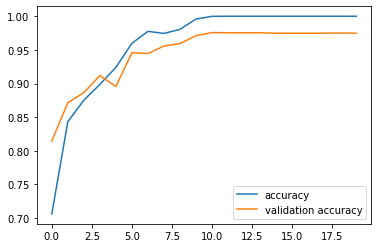

In [11]:
accuracy_graph(history)

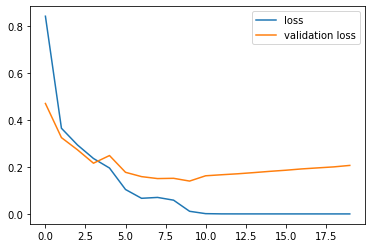

In [12]:
loss_graph(history)

In [14]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[889   1   1   8   5]
 [  0 845  30   0   0]
 [  0  48 827   0   0]
 [  8   1   0 862   4]
 [ 19   0   0   2 854]]


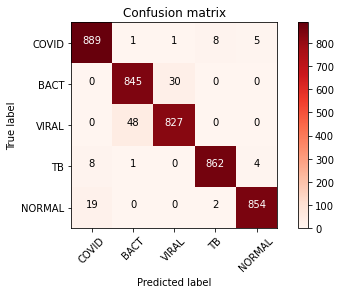

In [15]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [16]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       904
           1       0.94      0.97      0.95       875
           2       0.96      0.95      0.95       875
           3       0.99      0.99      0.99       875
           4       0.99      0.98      0.98       875

    accuracy                           0.97      4404
   macro avg       0.97      0.97      0.97      4404
weighted avg       0.97      0.97      0.97      4404

